<a href="https://colab.research.google.com/github/surajx/Algorithms/blob/master/Function_Approximation_in_Small_World_Options.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# @title Install Libraries


In [0]:
# @title Imports


import os
import glob
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import colors
from google.colab import files
import matplotlib.pyplot as plt


from collections import deque
from collections import defaultdict

import gym
from gym import spaces
from gym.envs.registration import register as register_new_gym_env
from gym.envs.registration import registry as gym_env_registry

%matplotlib inline

In [0]:
# @title Globals
# @markdown Global Variables and Constants

G_DEBUG = False

In [0]:
# @title Rooms Environment
# @markdown Custom Gym Environment for the Rooms Domain.
class Fourrooms(gym.Env):
    """
        Copyright: Pierre-Luc Bacon et.al.
        Source: https://github.com/pierrelux/option_critic/blob/master/fourrooms/fourrooms.py
    """    
    def __init__(self):
        layout = """\
wwwwwwwwwwwww
w     w     w
w     w     w
w           w
w     w     w
w     w     w
ww wwww     w
w     www www
w     w     w
w     w     w
w           w
w     w     w
wwwwwwwwwwwww
"""
        self.occupancy = np.array([list(map(lambda c: 1 if c=='w' else 0, line)) for line in layout.splitlines()])

        # From any state the agent can perform one of four actions, up, down, left or right
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Discrete(np.sum(self.occupancy == 0))

        self.directions = [np.array((-1,0)), np.array((1,0)), np.array((0,-1)), np.array((0,1))]
        self.rng = np.random.RandomState(1234)

        self.tostate = {}
        statenum = 0
        for i in range(13):
            for j in range(13):
                if self.occupancy[i, j] == 0:
                    self.tostate[(i,j)] = statenum
                    statenum += 1
        self.tocell = {v:k for k,v in self.tostate.items()}

        self.goal = 62
        self.init_states = list(range(self.observation_space.n))
        self.init_states.remove(self.goal)

    def empty_around(self, cell):
        avail = []
        for action in range(self.action_space.n):
            nextcell = tuple(cell + self.directions[action])
            if not self.occupancy[nextcell]:
                avail.append(nextcell)
        return avail

    def reset(self):
        state = self.rng.choice(self.init_states)
        self.currentcell = self.tocell[state]
        return state

    def step(self, action):
        """
        The agent can perform one of four actions,
        up, down, left or right, which have a stochastic effect. With probability 2/3, the actions
        cause the agent to move one cell in the corresponding direction, and with probability 1/3,
        the agent moves instead in one of the other three directions, each with 1/9 probability. In
        either case, if the movement would take the agent into a wall then the agent remains in the
        same cell.

        We consider a case in which rewards are zero on all state transitions.
        """
        nextcell = tuple(self.currentcell + self.directions[action])
        if not self.occupancy[nextcell]:
            if self.rng.uniform() < 1/3.:
                empty_cells = self.empty_around(self.currentcell)
                self.currentcell = empty_cells[self.rng.randint(len(empty_cells))]
            else:
                self.currentcell = nextcell

        state = self.tostate[self.currentcell]
        done = state == self.goal
        rew = 10. if done else -1
        return state, rew, done, None

if "Fourrooms-v0" not in gym_env_registry.env_specs:
    register_new_gym_env(
        id="Fourrooms-v0",
        entry_point="__main__:Fourrooms",
        timestep_limit=20000,
        reward_threshold=1
    )

In [0]:
# @title Gym Environments with Options



In [0]:
# @title Agent
# @markdown 

class Agent(object):
    """ Interface like class for Agent """
    
    def __init__(self, seed=1234):
        self.rng = np.random.RandomState(seed)
    
    def policy(self, state):
        raise NotImplemented()


In [0]:
# @title Tabular Agents
# @markdown


class TabularAgent(Agent):
    """ Tabular Agent """
    
    def __init__(self, seed=1234, initial_Q_value=0):
        self.Q = defaultdict(lambda:initial_Q_value)
        super().__init__(seed)
        
class EpsilonGreedyAgent(TabularAgent):
    
    def __init__(self, num_actions, seed=1234, initial_Q_value=0, 
                 epsilon=0.1, epsilon_decay=0.99):
        self.card_A = num_actions
        self.epsilon, self.epsilon_decay = epsilon, epsilon_decay        
        super().__init__(seed, initial_Q_value)
        
    def policy(self, state, isLearning=True):
        if isLearning and self.rng.uniform() < self.epsilon:
            self.epsilon *= self.epsilon_decay
            return self.rng.randint(self.card_A)
        self.epsilon *= self.epsilon_decay
        return int(np.argmax([self.Q[(state, a)] for  a in range(self.card_A)]))        
        
        
        
class TabularQLearningAgent(EpsilonGreedyAgent):
    """ Tabular Q-learning """
    
    def __init__(self, num_actions, seed=1234, initial_Q_value=0, epsilon=0.1, 
                 epsilon_decay=0.99, gamma=0.99, alpha=0.1):
        
        self.gamma, self.alpha = gamma, alpha        
        super().__init__(num_actions, seed, initial_Q_value, epsilon, epsilon_decay)
   
    def update(self, s_t, a_t, r_tp1, s_tp1, _):
        max_Q_s_tp1 = max([self.Q[(s_tp1, a)] for  a in range(self.card_A)])
        td_error = (r_tp1 + self.gamma * max_Q_s_tp1 - self.Q[(s_t, a_t)])
        self.Q[(s_t, a_t)] += self.alpha * td_error
        
class TabularSARSAAgent(EpsilonGreedyAgent):
    """ Tabular SARSA """
    
    def __init__(self, num_actions, seed=1234, initial_Q_value=0, epsilon=0.1, 
                 epsilon_decay=0.99, gamma=0.99, alpha=0.1):
        
        self.gamma, self.alpha = gamma, alpha        
        super().__init__(num_actions, seed, initial_Q_value, epsilon, epsilon_decay)
   
    def update(self, s_t, a_t, r_tp1, s_tp1, a_tp1):
        td_error = (r_tp1 + self.gamma * self.Q[(s_tp1, a_tp1)] - self.Q[(s_t, a_t)])
        self.Q[(s_t, a_t)] += self.alpha * td_error

In [0]:
# @title Options
# @markdown

In [0]:
# @title Agent-Environment Interaction
# @markdown

def load_agent(agent_name):
    """ Construct Agent Class"""

    main_mod = __import__('__main__')    
    assert(hasattr(main_mod, agent_name))
    agent_class = getattr(main_mod, agent_name)
    return agent_class


def learn(agent, env, max_episodes, window=100, log_file="learning_progress.log"):
    """ Agent-Environement Interaction Loop """
    
    episode = 0
    avg_rew = 0
    ep_moving_avg = 0
    moving_avg_window = deque(maxlen=window)
    log_file.write("episode,avg_reward_100ep\n")
    for episode in range(max_episodes):
        
        # Agent-Environement Interaction Loop for current episode.
        s_t = env.reset()
        a_t = agent.policy(s_t)
        done = False
        ep_rew = 0
        while not done:
            s_tp1, r_tp1, done, _ = env.step(a_t)
            a_tp1 = agent.policy(s_tp1)
            agent.update(s_t, a_t, r_tp1, s_tp1, a_tp1)
            s_t, a_t = s_tp1, a_tp1
            ep_rew += r_tp1
            
        # Running Total average.
        avg_rew += (ep_rew - avg_rew) / (episode + 1)
            
        # Evaluation of running moving average.
        if episode >= window:
            ep_moving_avg += (ep_rew - moving_avg_window[0]) / window
        else:
            ep_moving_avg = avg_rew # store full running average till window is full.
        moving_avg_window.append(ep_rew)
        
        # Print Moving and Total average every 5000 episodes.
        if G_DEBUG and (episode % 2 == 0 or episode + 1 == max_episodes):
            print("[{}] Avg. reward per episode: {}".format(episode, avg_rew))
            print("[{}] Last 100 Episodes Avg. Reward: {}".format(episode, ep_moving_avg))
        
        log_file.write("{},{}\n".format(episode, ep_moving_avg))
        
    return ep_moving_avg
        
def evaluate(agent, env, max_episodes):
    """ Evaluation for learned agent """
    
    episode = 0
    avg_rew = 0
    for episode in range(max_episodes):
        
        # Agent-Environement Interaction Loop for current episode.
        s_t = env.reset()
        a_t = agent.policy(s_t, isLearning=False)
        done = False
        ep_rew = 0
        while not done:
            s_tp1, r_tp1, done, _ = env.step(a_t)
            a_tp1 = agent.policy(s_tp1, isLearning=False)
            s_t, a_t = s_tp1, a_tp1
            ep_rew += r_tp1
            
        # Running Total average.
        avg_rew += (ep_rew - avg_rew) / (episode + 1)
        
    return avg_rew    
    

def runner(run_id, env_name, env_args, agent_name, agent_args):
    """ Run single intance f  """
    env = gym.make(env_name)    
    agent_class = load_agent(agent_name)
    agent = agent_class(env.action_space.n, **agent_args)
    
    output_filename = run_id+"/"+env_name+"/"+agent_name+'_'+env_name+'_'+str(agent_args['seed'])+'.csv'
    os.makedirs(os.path.dirname(output_filename), exist_ok=True)
    log_file_desc = open(output_filename, 'w')

    learn_avg_rew = learn(agent, env, env_args['max_train_episodes'], log_file=log_file_desc)
    log_file_desc.close()
    print("[Env: {}, Agent: {}, seed: {}] Learning Avg. reward over {} episodes: {}"
          .format(env_name, agent_name, agent_args['seed'], 
                  env_args['max_train_episodes'], learn_avg_rew))
    eval_avg_rew = evaluate(agent, env, env_args['max_eval_episodes'])
    print("[Env: {}, Agent: {}] Evaluation Avg. reward over {} episodes: {}"
          .format(env_name, agent_name, env_args['max_eval_episodes'], eval_avg_rew))
    

In [0]:
# @title Plots
# @markdown Plotting

def get_data_for_all_seeds(run_id, env_name, agent_name):
    """ Aggregate data files for all seeds """
    data_list = []
    for csv_file in glob.glob(run_id+"/"+env_name+"/"+agent_name+"*.csv"):
        df = pd.read_csv(csv_file)
        data_list.append(df)
    return data_list

def get_stats_for_data_list(data_list):
    """ Evaluate mean and standard deviation of each data fram """
    
    keyDF = (pd.concat(data_list, axis=0, keys=range(len(data_list)))
            .swaplevel(0, 1, axis=0)
            .sort_index(axis=0)
            .groupby(level=0, axis=0))
    
    stats = (keyDF.mean(), keyDF.std().div(np.sqrt(len(data_list))).mul(2.0))
    return stats

def add_agent_data_to_plot(plt, stat, plt_args):
    meanDF, stderrDF = stat
    plt.plot(meanDF["episode"], meanDF["avg_reward_100ep"], 'k', 
             color=plt_args['plt_color'], label=plt_args['plt_name'])
    plt.fill_between(meanDF["episode"], 
                     meanDF["avg_reward_100ep"]-stderrDF["avg_reward_100ep"], 
                     meanDF["avg_reward_100ep"]+stderrDF["avg_reward_100ep"], 
                     alpha=0.8, edgecolor='none', facecolor=plt_args['plt_facecolor'])
                
def get_plot_for_environments(envs, agent_plt_args, run_id):
    agents = agent_plt_args.keys()    
    for env_name in envs.keys():
        img = plt.figure(figsize=(5, 3))
        plt.title(env_name)
        plt.ylabel("Average Reward")
        plt.xlabel("Episodes")        
        plt.xlim(0, envs[env_name]['plt_x_limit'])
        for agent_name in agents:
            stat = get_stats_for_data_list(get_data_for_all_seeds(run_id, env_name, agent_name))
            plt_args = agent_plt_args[agent_name]
            add_agent_data_to_plot(plt, stat, plt_args)
        plt.legend(loc=envs[env_name]['plt_legend_loc'])

In [0]:
# @title configurations

G_ENVS = {
#     'Taxi-v2': {
#         'max_train_episodes': 50000, 
#         'max_eval_episodes': 100,
#         'plt_x_limit': 1000
#         'plt_legend_loc': 2
#     },
    'Fourrooms-v0': {
        'max_train_episodes': 5000, 
        'max_eval_episodes': 100,
        'plt_x_limit': 200,
        'plt_legend_loc': 4           # Lower Left
    }
}
G_AGENT_PLT_ARGS = {
    'TabularQLearningAgent': {
        'plt_name': 'Q-learning',
        'plt_color': '#239b56',       #Green
        'plt_facecolor': '#82e0aa'  
    },
    'TabularSARSAAgent': {
        'plt_name': 'SARSA',
        'plt_color': '#CC4F1B',       #Orange
        'plt_facecolor': '#FF9848'  
    }
}
G_AGENTS = G_AGENT_PLT_ARGS.keys()
G_NUM_AGENT_RUNS = 2

In [133]:
# @title Run Multiple Experiments
def multi_experiment_runner():
    run_id = 'RUN_'+datetime.now().strftime("%Y%m%d%H%M%S")
    for env_name in G_ENVS.keys():
        for agent_name in G_AGENTS:
            seeds = np.random.choice(range(1000, 10000), G_NUM_AGENT_RUNS, replace=False)
            for seed in seeds:
                agent_args = {
                    'seed' : seed
                }
                env_args = G_ENVS[env_name]
                runner(run_id, env_name, env_args, agent_name, agent_args)
                
    return run_id

G_RUN_ID = multi_experiment_runner()

[Env: Fourrooms-v0, Agent: TabularQLearningAgent, seed: 8516] Learning Avg. reward over 5000 episodes: -0.7700000000000476
[Env: Fourrooms-v0, Agent: TabularQLearningAgent] Evaluation Avg. reward over 100 episodes: -0.6900000000000002
[Env: Fourrooms-v0, Agent: TabularQLearningAgent, seed: 8119] Learning Avg. reward over 5000 episodes: -1.4300000000000426
[Env: Fourrooms-v0, Agent: TabularQLearningAgent] Evaluation Avg. reward over 100 episodes: -0.81
[Env: Fourrooms-v0, Agent: TabularSARSAAgent, seed: 4175] Learning Avg. reward over 5000 episodes: -2.020000000000057
[Env: Fourrooms-v0, Agent: TabularSARSAAgent] Evaluation Avg. reward over 100 episodes: -1.8199999999999998
[Env: Fourrooms-v0, Agent: TabularSARSAAgent, seed: 3596] Learning Avg. reward over 5000 episodes: -1.2500000000000673
[Env: Fourrooms-v0, Agent: TabularSARSAAgent] Evaluation Avg. reward over 100 episodes: -0.7799999999999999


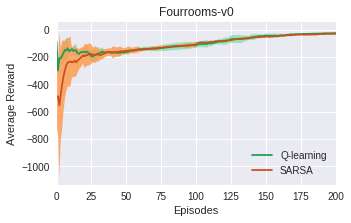

In [157]:
get_plot_for_environments(G_ENVS, G_AGENT_PLT_ARGS, G_RUN_ID)